# Homework #2: Music Auto Tagging (Multi-Label Classification)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

## Importing Packages

In [1]:
import warnings
import multiprocessing
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import os
import torchaudio
import torch
import torch.nn as nn
from sklearn import metrics

from tqdm.notebook import tqdm
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import IPython.display as ipd

# Data Checking


In [2]:
# use 50 top tags
TAGS = ['guitar','classical', 'slow','techno','strings','drums','electronic','rock',
        'fast','piano','ambient','beat','violin','vocal','synth','female','indian',
        'opera','male','singing','vocals','no vocals','harpsichord','loud','quiet',
        'flute', 'woman', 'male vocal', 'no vocal', 'pop','soft','sitar', 'solo',
        'man', 'classic', 'choir', 'voice', 'new age', 'dance', 'male voice',
        'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird', 'country',
        'metal', 'female voice', 'choral']

In [3]:
df = pd.read_csv("./annotations_final.csv", sep="\t", index_col=0)
item = df.iloc[0]
item[item != 0] # check annotated tags

classical                                                    1
strings                                                      1
opera                                                        1
violin                                                       1
mp3_path     f/american_bach_soloists-j_s__bach_solo_cantat...
Name: 2, dtype: object

In [4]:
# filter out, un-annnotated dataset
df_filter =  df[TAGS].sum(axis=1)
use_id = df_filter[df_filter != 0].index
df = df.loc[use_id]

<AxesSubplot: >

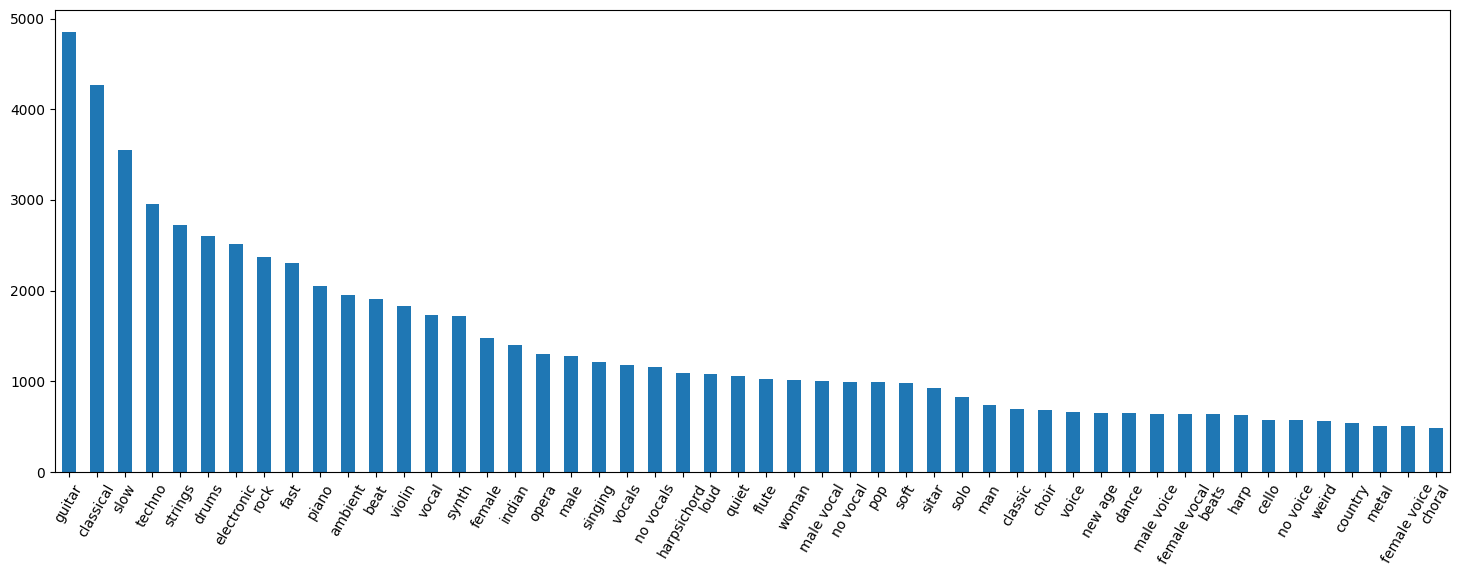

In [5]:
df[TAGS].sum().plot.bar(figsize=(18,6),rot=60) # check data distribution

# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [6]:
train = []
valid = []
test = []
id_to_path = {}
for idx in range(len(df)):
  item = df.iloc[idx]
  id = item.name
  path = item['mp3_path']
  folder = path.split("/")[0]
  id_to_path[id] = path
  if folder in "012ab":
    train.append(id)# split = "train"
  elif folder == "c":    
    valid.append(id)# split = "valid"
  elif folder in "d":
    test.append(id)# split = "test"

In [7]:
total = len(train) + len(valid) + len(test)
total, len(train) / total, len(valid)/ total, len(test)/ total

(9074, 0.6839321137315406, 0.16850341635441923, 0.14756446991404013)

In [8]:
df = df[TAGS]

In [9]:
df_train = df.loc[train]
df_valid = df.loc[valid]
df_test = df.loc[test]

In [10]:
# Data processing setup.
SR = 16000
BATCH_SIZE = 16

## Dataset & DataLoader

In [11]:
import AudioDataset
import torchvision

### Computing statistics of the training set
The code below compute mean, standard deviation and the minimum temporal dimension size, and use them for preprocessing inputs.

In [12]:
BATCH_SIZE = 16
num_workers = 2
sample_rate = 16000
duration = 3
input_length =  sample_rate * duration
data_path = "./waveform"
tr_data = AudioDataset.AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN')
va_data = AudioDataset.AudioDataset(data_path, input_length, df_valid, id_to_path, 'VALID')
te_data = AudioDataset.AudioDataset(data_path, input_length, df_test, id_to_path, 'TEST')
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [13]:
# Source: https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='none'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.binary_cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [14]:
class Runner(object):
  def __init__(self, model, lr, weight_decay, sr, tags):
    self.optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.criterion = FocalLoss().to(self.device)
    self.tags = tags

  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
  def run(self, dataloader, epoch, mode='TRAIN'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
    for x, y in pbar:
      # Move mini-batch to the desired device.
      x = x.to(self.device)
      y = y.to(self.device)
      # Feed forward the model.
      prediction = self.model(x)
      # Compute the loss.
      loss = self.criterion(prediction, y)
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss

  def test(self, dataloader):
    self.model.eval()
    epoch_loss = 0
    predictions = []
    labels = []
    pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
    for x, y in pbar:
      x = x.to(self.device)
      y = y.to(self.device)
      x = x.transpose(1,0) # pre-batch in audio loader (chunk, 1, waveform)
      prediction = self.model(x)
      prediction = prediction.mean(dim=0, keepdim=True) # average chunk audio
      loss = self.criterion(prediction, y) 
      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
      predictions.extend(prediction.detach().cpu().numpy())
      labels.extend(y.detach().cpu().numpy())
    epoch_loss = epoch_loss / len(loader_test.dataset)
    roc_aucs, pr_aucs, tag_wise_rocaucs = self.get_auc(predictions, labels)
    return roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs

  # Early stopping function for given validation loss
  def early_stop(self, loss, epoch):
    self.scheduler.step(loss, epoch)
    self.learning_rate = self.optimizer.param_groups[0]['lr']
    stop = self.learning_rate < self.stopping_rate
    return stop

  def get_auc(self, predictions, labels):
    roc_aucs = metrics.roc_auc_score(labels, predictions, average='macro')
    pr_aucs = metrics.average_precision_score(labels, predictions, average='macro')
    tag_wise_predictions = np.stack(predictions).T
    tag_wise_labels = np.stack(labels).T
    tag_wise_rocaucs = {}
    for tag, logit, label in zip(self.tags, tag_wise_predictions, tag_wise_labels):
      tag_wise_rocaucs[tag] = metrics.roc_auc_score(label, logit)
    return roc_aucs, pr_aucs, tag_wise_rocaucs

In [15]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [16]:
import torch.nn as nn

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        #========================================
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(output_channels)
        self.elu = nn.ELU()
        self.mp = nn.MaxPool2d(pooling, stride)
        self.dropout = nn.Dropout(dropout)
        #========================================
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.elu(out)
        out = self.mp(out)
        out = self.dropout(out)
        return out

class CNN2D(nn.Module):
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50):
        super(CNN2D, self).__init__()
        
        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)
        #========================================
        self.layer1 = Conv_2d(1, 64, kernel_size=3, pooling=(4, 4), stride=2, padding=(3,3))
        self.layer2 = Conv_2d(64, 128, kernel_size=3, pooling=(3, 3), stride=2, padding=(6,8))
        self.layer3 = Conv_2d(128, 128, kernel_size=3, pooling=(3, 3), stride=2, padding=(2,4))
        self.layer4 = Conv_2d(128, 1024, kernel_size=3, pooling=(1, 1), stride=1, padding='same')
        self.layer5 = Conv_2d(1024, 128, kernel_size=3, pooling=(1, 1), stride=1, padding='same')
        self.layer6 = Conv_2d(128, 64, kernel_size=1, pooling=(2, 5), stride=1, padding=(0,0))
        #========================================
        self.linear = nn.Linear(64, n_class)
    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = nn.Softmax()(x) 
        return x

In [17]:
# Train CNN2D
model = CNN2D()
runner = Runner(model=model, lr = LR, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN')
  valid_loss = runner.run(loader_valid, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/5] [Train Loss: 0.2051] [Valid Loss: 0.1902]


TRAIN Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/5] [Train Loss: 0.1879] [Valid Loss: 0.1859]


TRAIN Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/5] [Train Loss: 0.1799] [Valid Loss: 0.1768]


TRAIN Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/5] [Train Loss: 0.1764] [Valid Loss: 0.1782]


TRAIN Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/5] [Train Loss: 0.1727] [Valid Loss: 0.1753]


In [18]:
# Evaluate CNN2D
roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss},  roc_auc={roc_aucs}, pr_auc={pr_aucs}')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.3263422911245963,  roc_auc=0.8470197429700711, pr_auc=0.3223696518397546


<AxesSubplot: >

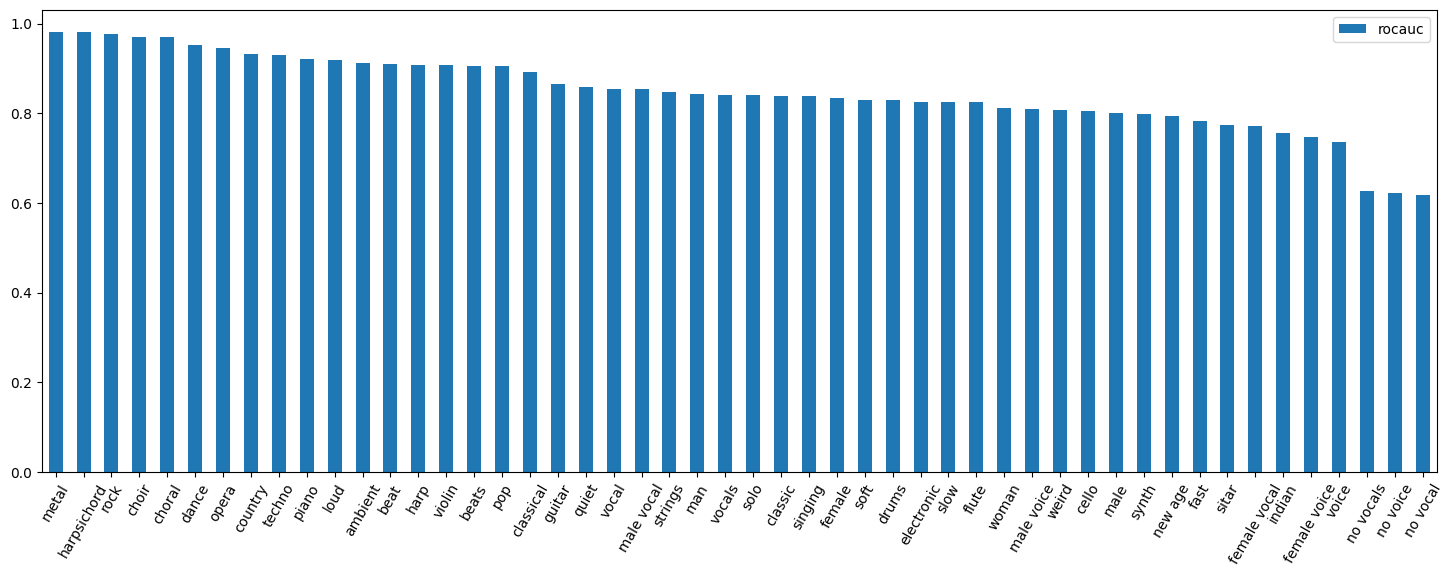

In [19]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.